In [34]:
# standard libs
import os
import sys
import logging
import json

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor, AgePredictorComparison
from preprocessing import *
from fragmented_cities import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap
from functools import partial

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [5]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
%load_ext autoreload
%autoreload 2

## Data

In [78]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [ ]:
data_geom = pd.read_csv(os.path.join('..', 'data', 'france-gov_geom.csv'))

In [177]:
data_boundaries_fra = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm36_FRA_4.shp'))

In [162]:
data_boundaries = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm404.gpkg'))

In [144]:
european_countries = [
'Albania',
'Austria',
'Belgium',
'Bulgaria',
'Croatia',
'Cyprus',
'Czechia',
'Denmark',
'Estonia',
'Finland',
'France',
'Germany',
'Greece',
'Greenland',
'Hungary',
'Iceland',
'Ireland',
'Italy',
'Kosovo',
'Liechtenstein',
'Lithuania',
'Luxembourg',
'Monaco',
'Montenegro',
'Netherlands',
'North Macedonia',
'Northern Cyprus',
'Norway',
'Poland',
'Portugal',
'Romania',
'San Marino',
'Serbia',
'Slovakia',
'Slovenia',
'Spain',
'Sweden',
'Switzerland',
'Ukraine',
# 'United Kingdom',
]
eu_countries = [
'austria',
'belgium',
'bulgaria',
'croatia',
'cyprus',
'czechia',
'denmark',
'estonia',
'finland',
'france',
'germany',
'greece',
'hungary',
'ireland',
'italy',
'latvia',
'lithuania',
'luxembourg',
'malta',
'netherlands',
'poland',
'portugal',
'romania',
'slovakia',
'slovenia',
'spain',
'sweden',
'switzerland', # included even not in eu
]
data_boundaries_europe = data_boundaries[data_boundaries['NAME_0'].isin(european_countries)]

## Determining fragmented cities semi-automatically

### STEP 0: Preprocessing

In [170]:
df = data_boundaries_europe.copy()
df = df.drop_duplicates(subset=['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'NAME_4'])

### STEP 1: Europe-wide city clustering based on similar names to get an intuition of possibly fragmented regions (GADM level 4)

In [166]:
for level in [3, 4]:

    candidates = {}
    for country in european_countries:
        data_boundaries_country = df[df['NAME_0'] == country]
        candidates[country] = get_fragmented_cities_clustering(data_boundaries_country, level=level)

    with open(os.path.join('..', 'data', f'fragmented-cities-candidates-clustering-level-{level}.json'), 'w', encoding='utf8') as f:
        json.dump(candidates, f, sort_keys=True, indent=4, ensure_ascii=False)


### STEP 2: Analysis of potential fragmented regions

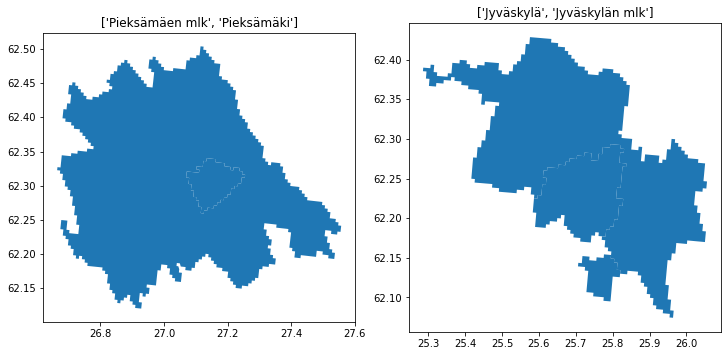

In [181]:
# Finland (level 4)
df_fn = data_boundaries[data_boundaries['NAME_0'] == 'Finland'].copy()
frag_cities_fn = get_fragmented_cities_clustering(df_fn, level=4)

# mlk (Finnish): Abbreviation of maalaiskunta ("rural municipality")
mlk_frag_cities_fn = [frags for frags in frag_cities_fn if any('mlk' in frag for frag in frags)]
visual_validation(mlk_frag_cities_fn, df_fn, level=4)
# --> tbd if considered as fragmented city / region!

<AxesSubplot:>

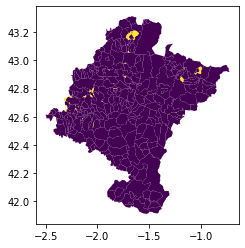

In [179]:
# Facería XX regions in Spain (level 4)
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain')].copy()
df['Facería_region'] = df['NAME_4'].str.contains('Facería')
df[df['NAME_2'] == 'Navarra'].plot(column='Facería_region')
# --> not a fragmented city / region!

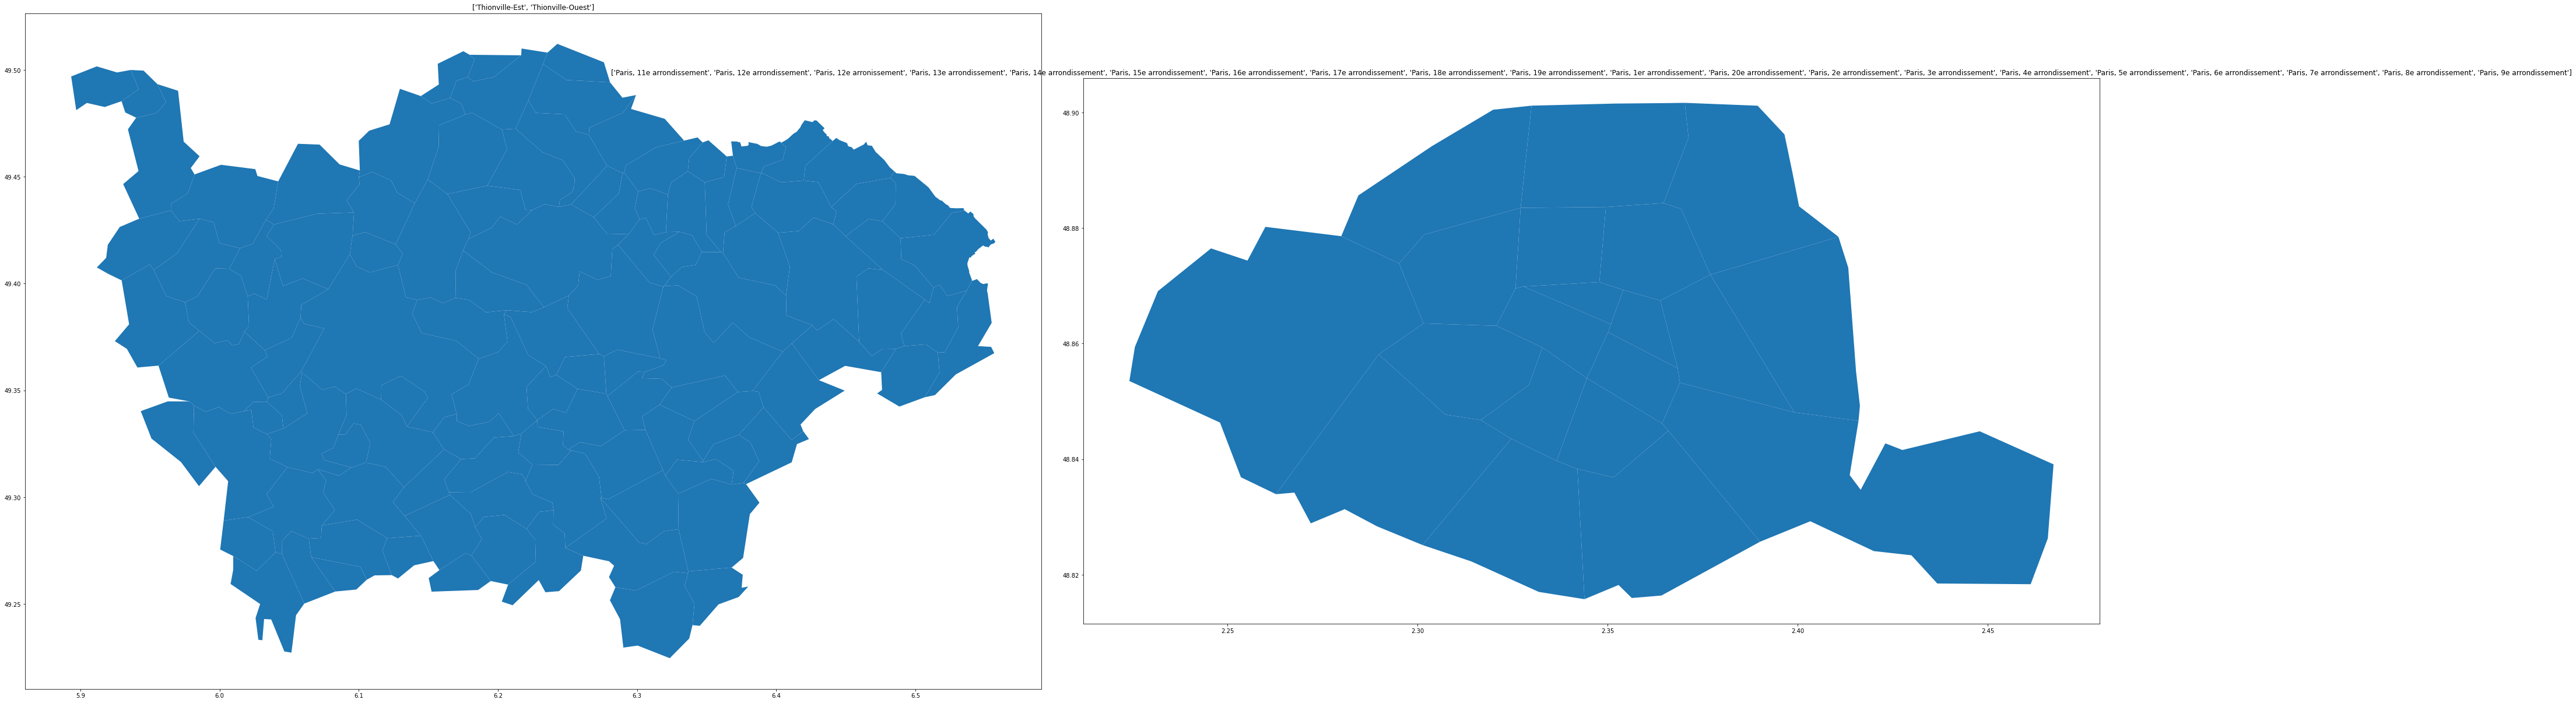

In [194]:
# France (level 3)
df_fr = data_boundaries[data_boundaries['NAME_0'] == 'France'].copy()
frag_cities_fr = get_fragmented_cities_clustering(df_fr, level=3)
visual_validation(frag_cities_fr, df_fr, level=3)

# visualizations.plot_attribute_on_map(data_france_region, data_geo_region, 'street_closeness_global_closest_street', boundaries_df=data_boundaries_region) #, vmin=0.001, vmax=0.00001)

# --> Paris: fragmented city / to be merged! Thionville tbd!


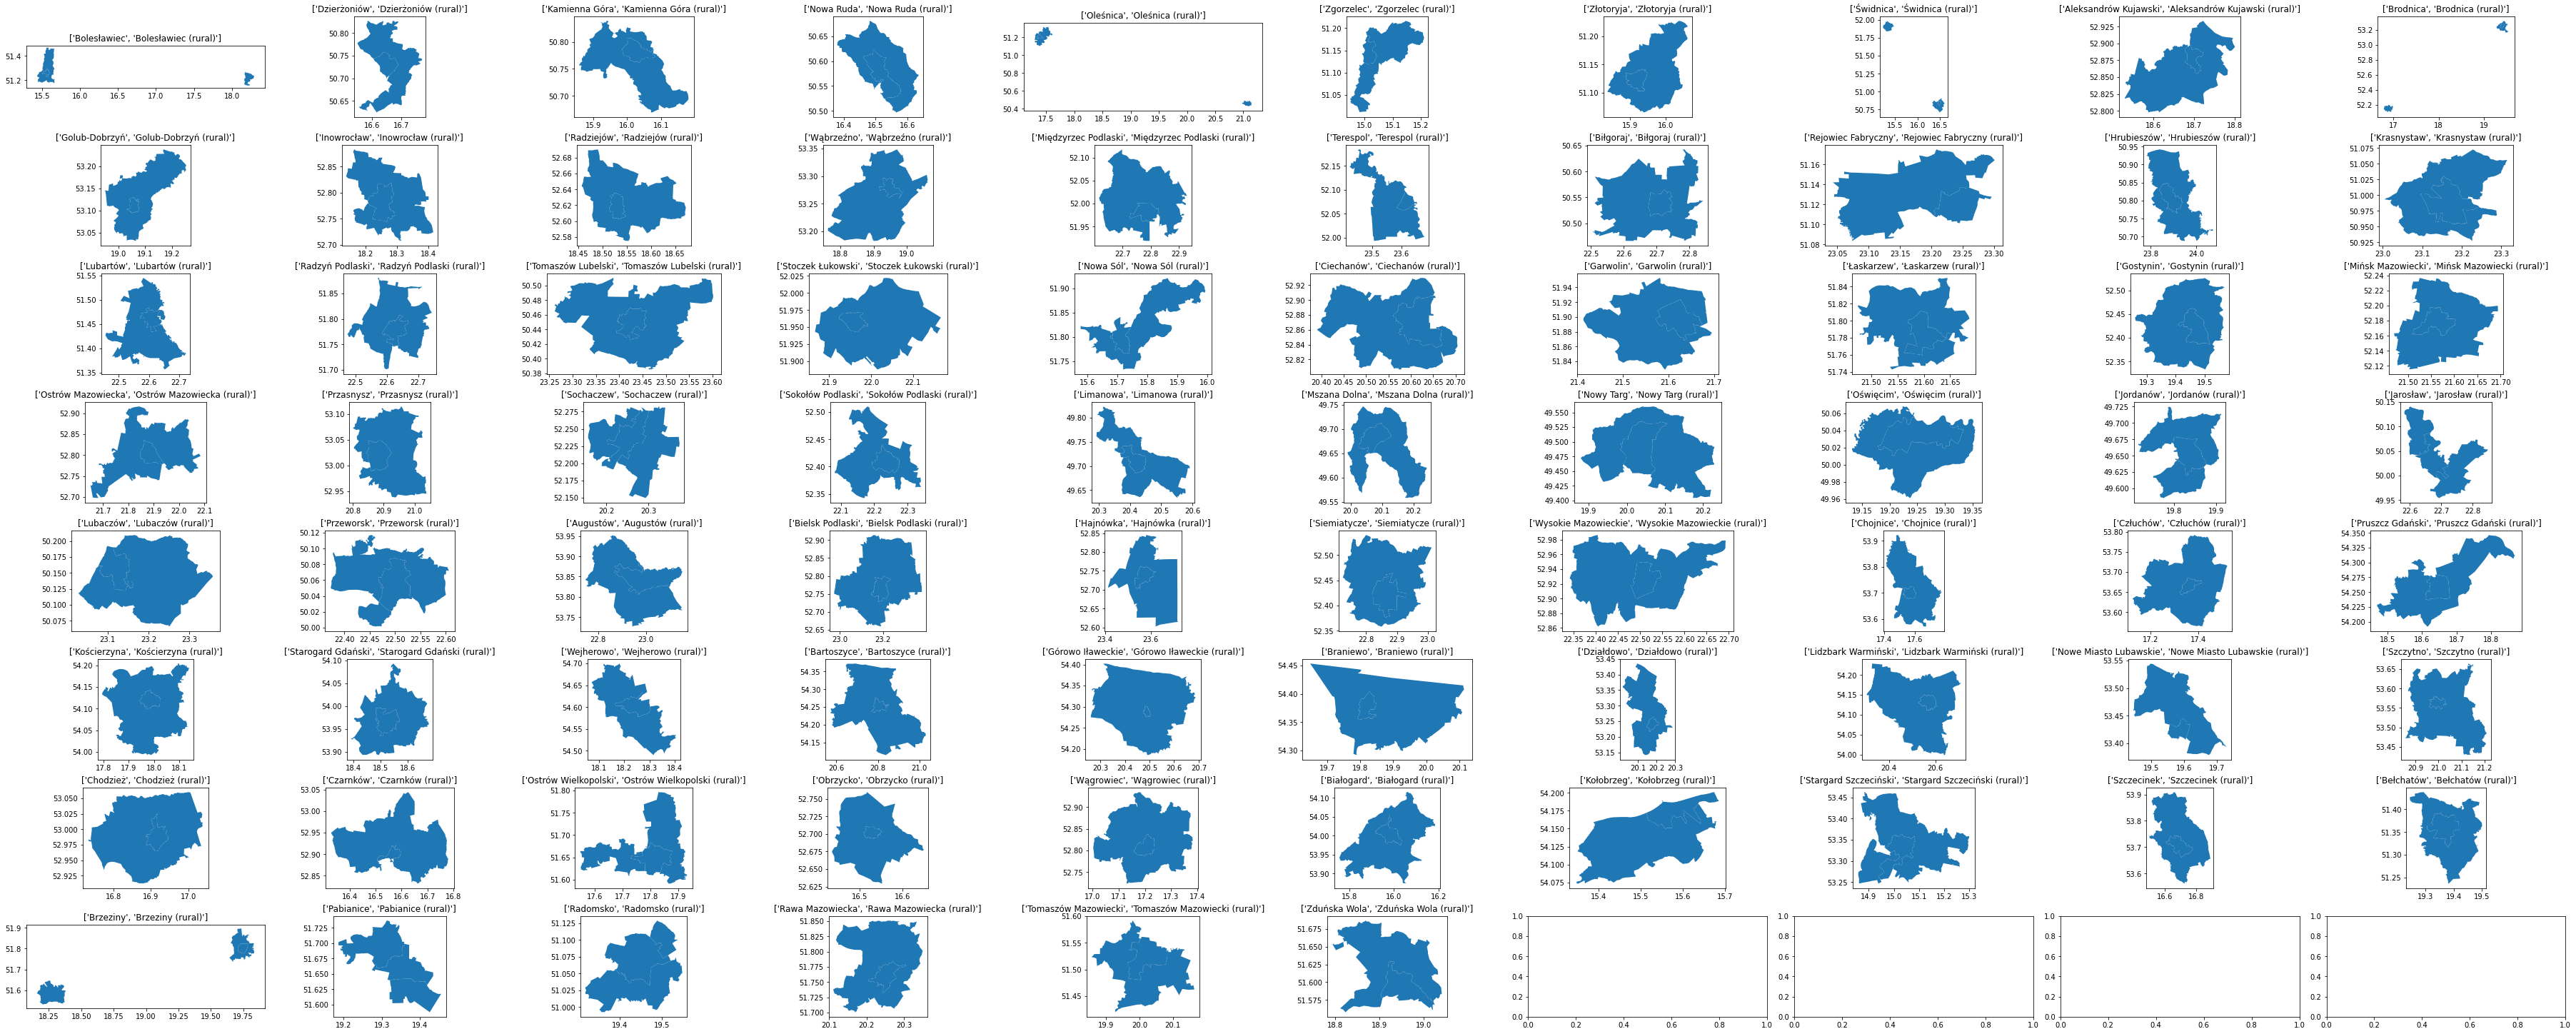

In [191]:
# Poland (level 3)
df_pl = data_boundaries[data_boundaries['NAME_0'] == 'Poland'].copy()
frag_cities_pl = get_fragmented_cities_clustering(df_pl, level=3)

# mlk (Finnish): Abbreviation of maalaiskunta ("rural municipality")
mlk_frag_cities_pl = [frags for frags in frag_cities_pl if any('(rural)' in frag for frag in frags)]
visual_validation(mlk_frag_cities_pl, df_pl, level=3)
# --> tbd if 'rural' considered as fragmented city / region!

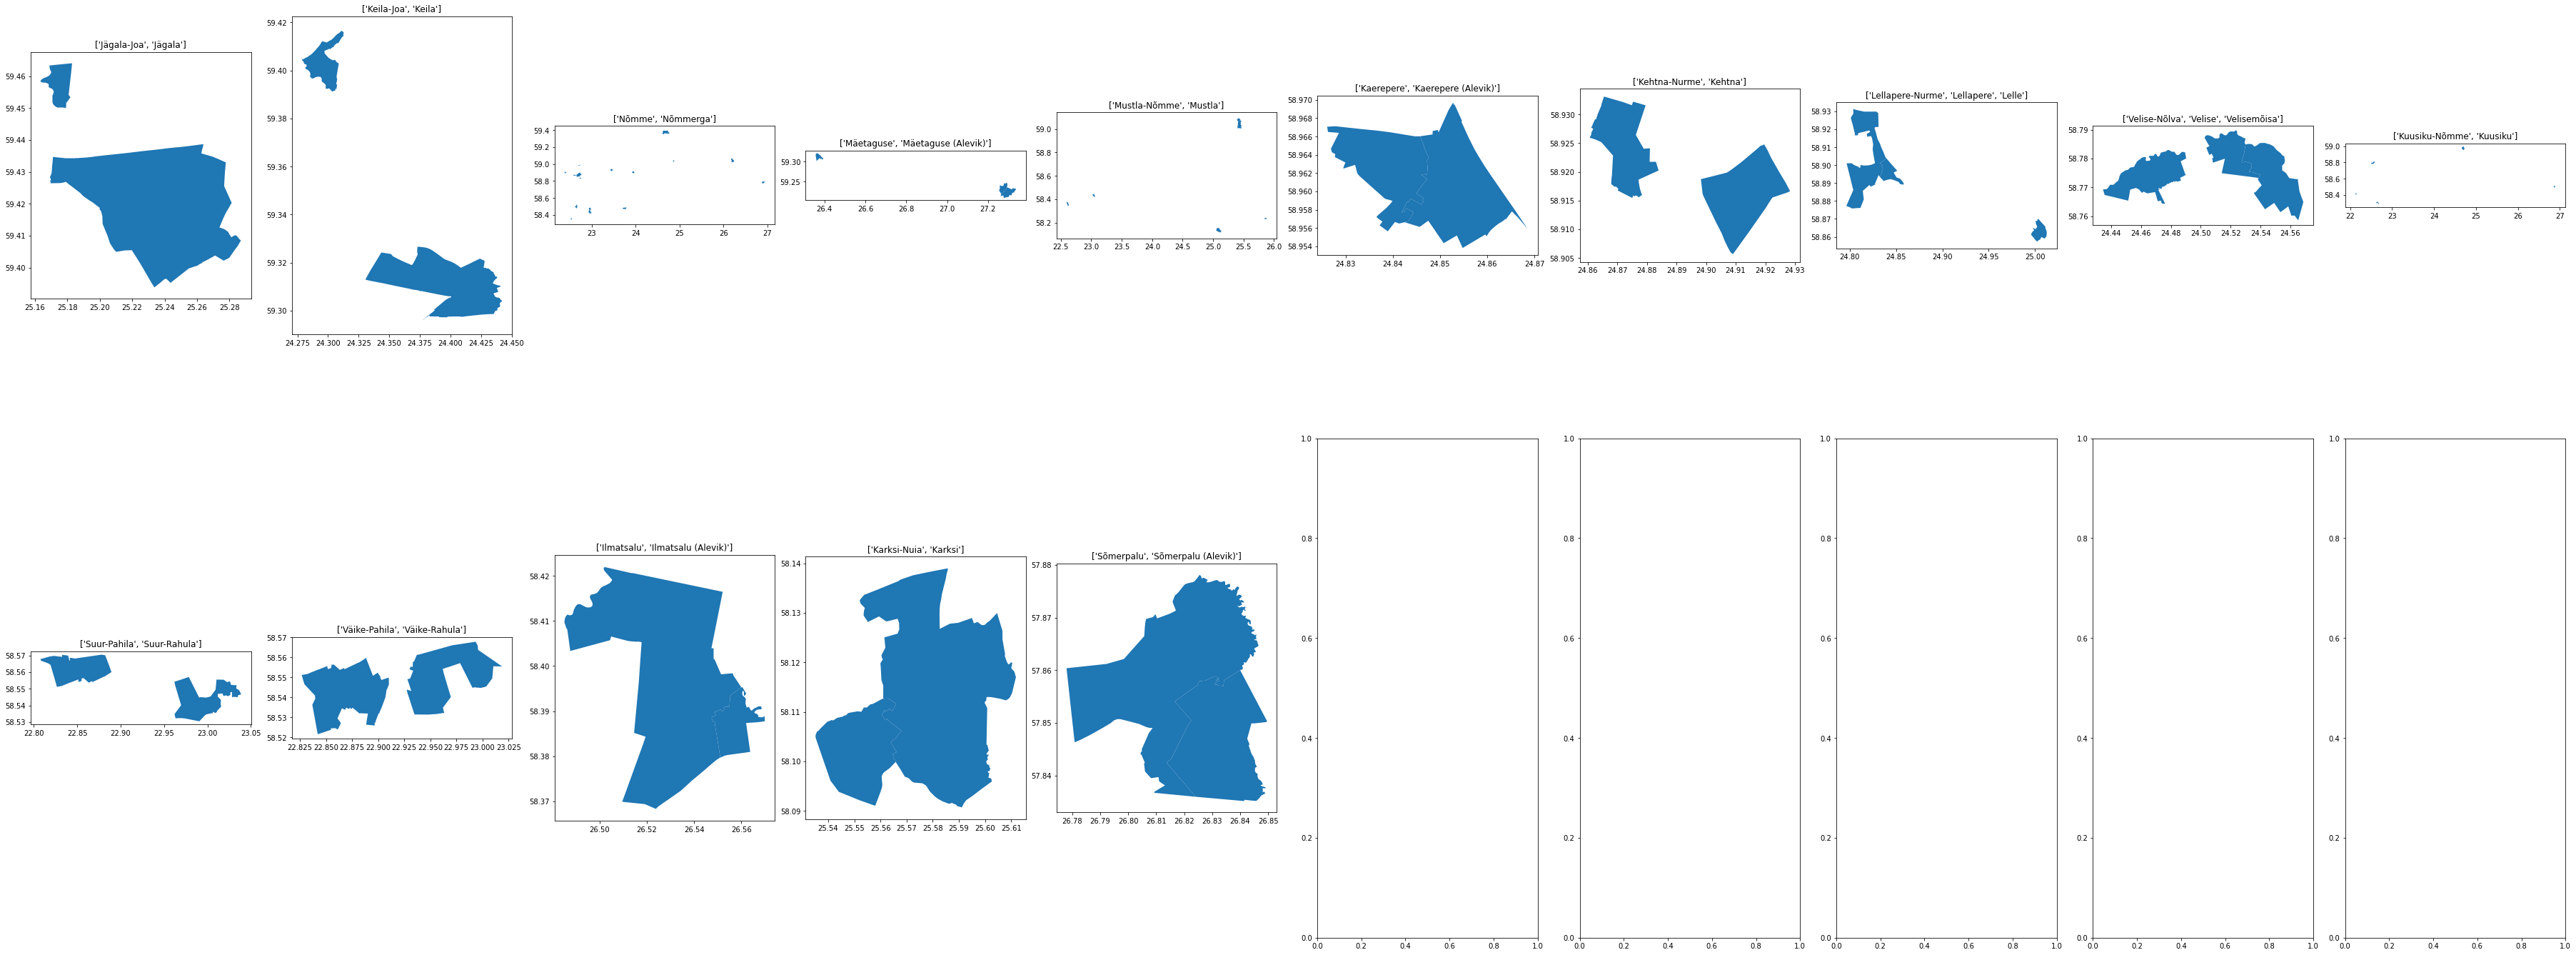

In [184]:
# Estonia (level 3)
potential_substrings = ['Joa', 'Alevik', 'Pahila', 'Rahula', 'Nõmme', 'Nurme'] # used at least twice
potential_substrings_2 = ['Nõlva', 'Nuia'] # used just once

df_es = data_boundaries[data_boundaries['NAME_0'] == 'Estonia'].copy()
frag_cities_es = get_fragmented_cities_clustering(df_es, level=3)
mlk_frag_cities_es = [frags for frags in frag_cities_es if any(s in frag for frag in frags for s in potential_substrings + potential_substrings_2)]
visual_validation(mlk_frag_cities_es, df_es, level=3)

# --> tbd if 'Alevik' (eng.: village) is considered as fragmented city / region; all others are not!

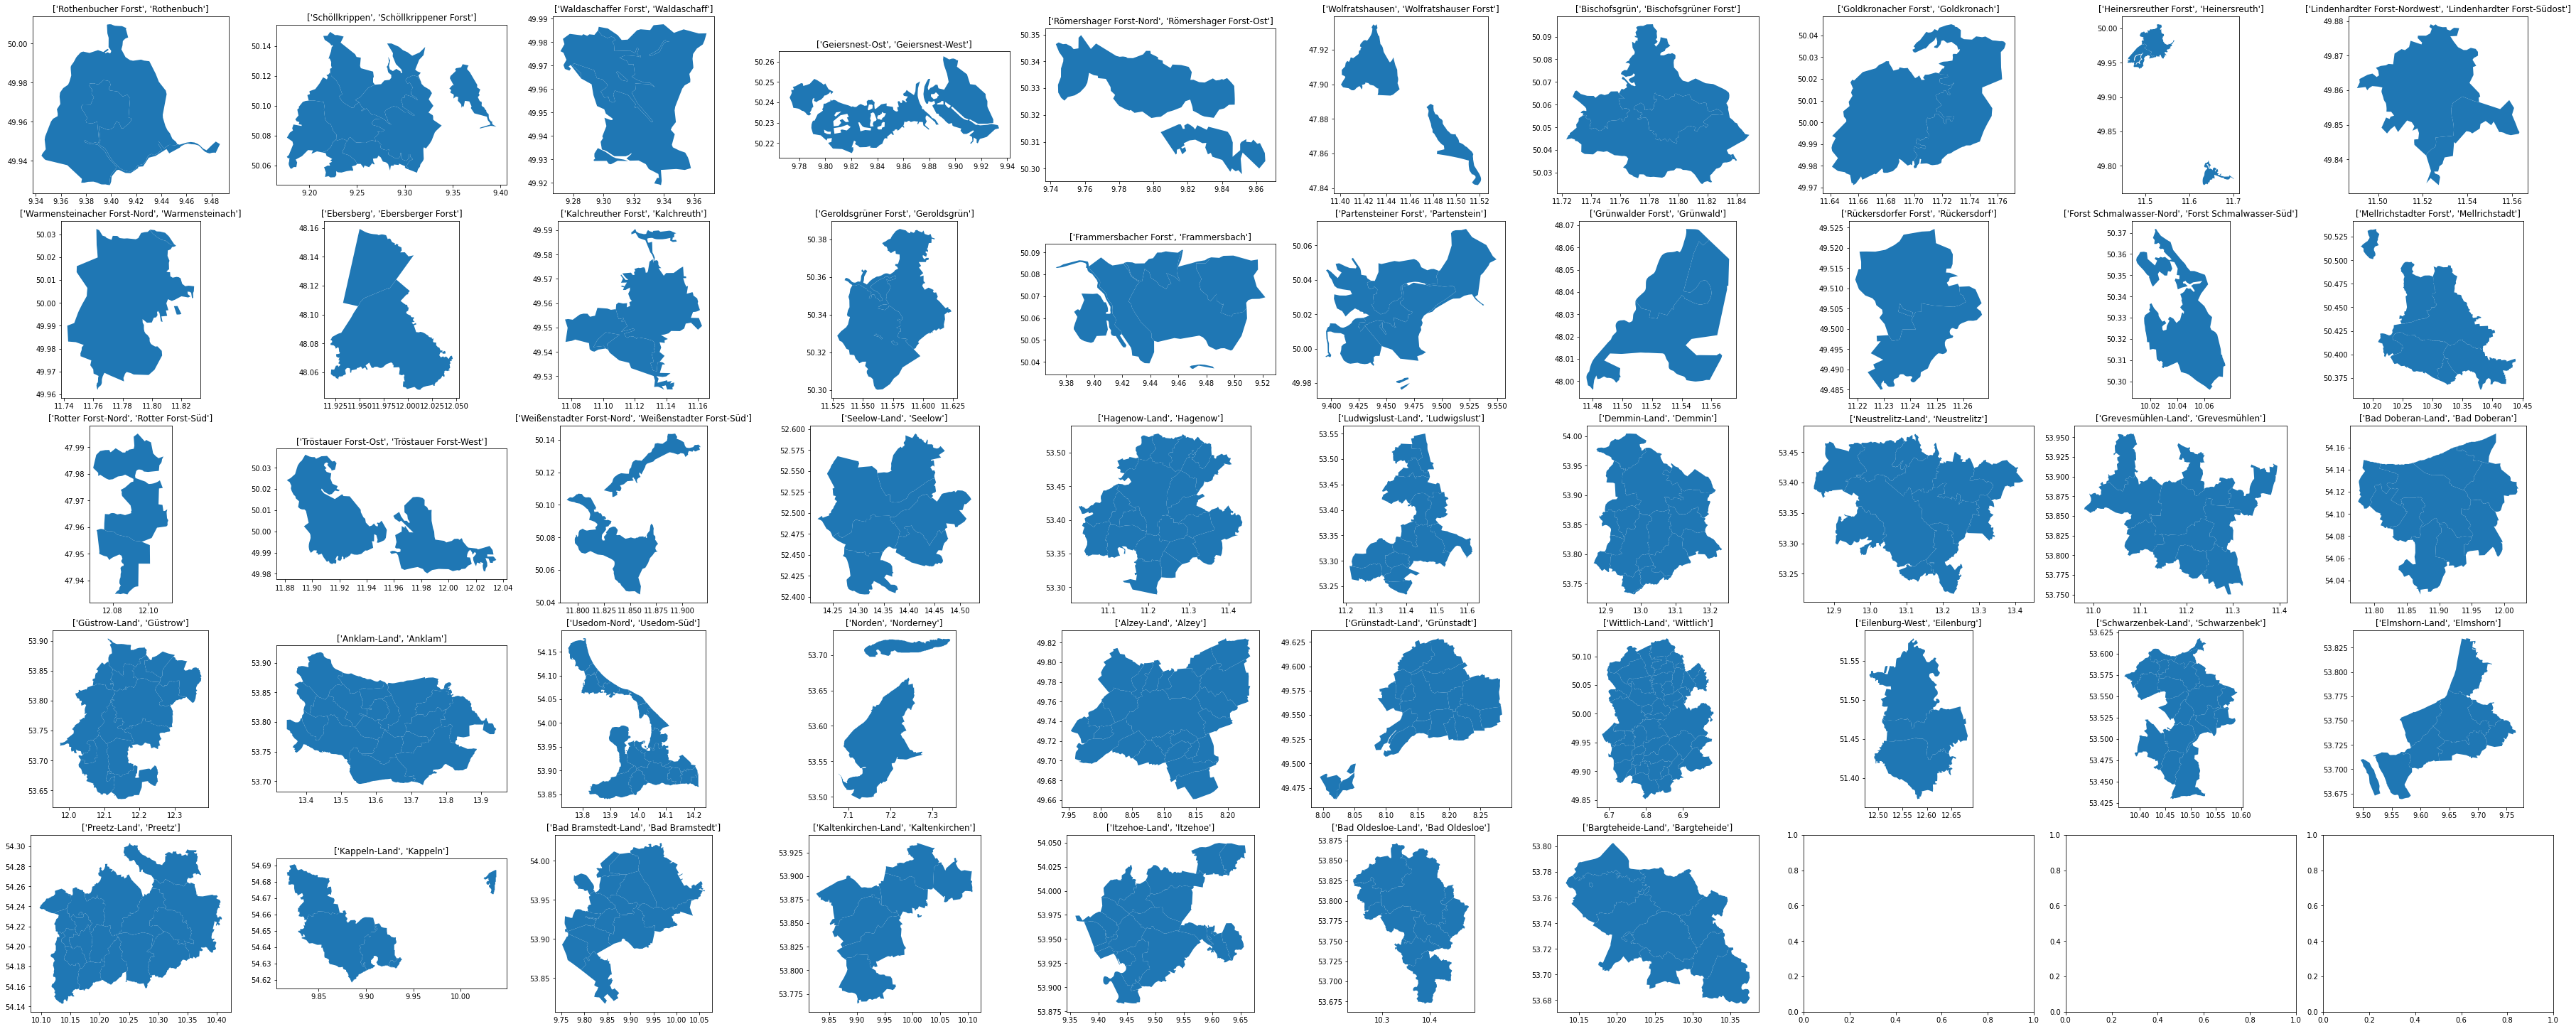

In [193]:
# Germany (level 3)
potential_substrings = ['-Land', 'Nord', 'Süd', 'West', 'Ost', 'Forst'] # used at least twice

df_ger = data_boundaries[data_boundaries['NAME_0'] == 'Germany'].copy()
frag_cities_es = get_fragmented_cities_clustering(df_ger, level=3)
mlk_frag_cities_es = [frags for frags in frag_cities_es if any(s in frag for frag in frags for s in potential_substrings)]
visual_validation(mlk_frag_cities_es, df_ger, level=3)

# --> ?

In [196]:
# Italy (level 3)

# --> ?

#### TBD

In [192]:
# Should rural areas and rural municipalities be joined? If no, ignore 'Alevik', 'mlk' and 'rural' substrings.

# -> Not for now (https://docs.google.com/document/d/1F02kWeotuDwPUYUL7PlYqIzgDyH6ga4aquea0OyE8I4/edit?usp=sharing)

### STEP 3a: Determining substrings which hint fragmented cities

In [ ]:
# France: Sud|Est|Ouest|Nord|Canton|arrondissement (if rural areas around small cities are to be merged)
# France: Sud|Est|Ouest|Nord|arrondissement (else)

### STEP 3b: Determining special cases of fragmented cities which have to be hard-coded

In [212]:
special_cases_lvl4 = [tuple(("Montluçon",
[
    "Montluçon",
    "Montluçon-Est (4e Canton)",
    "Montluçon-Nord-Est (1er Canton)",
    "Montluçon-Ouest (2e Canton)",
    "Montluçon-Sud (3e Canton)",
    "Domérat-Montluçon-Nord-Ouest" # no matched because of Domérat prefix, but is essentially part of the region (see plot in Experiments section)
]))]

### STEP 4: Determining fragmented city based on regex parsing for substrings

In [172]:
for level in [3, 4]:

    candidates = {}
    for country in european_countries:
        data_boundaries_country = data_boundaries_fra[data_boundaries_fra['NAME_0'] == country]
        candidates[country] = get_fragmented_cities_regex(data_boundaries_country, level=level)

    with open(os.path.join('..', 'data', f'fragmented-cities-candidates-regex-level-{level}.json'), 'w', encoding='utf8') as f:
        json.dump(candidates, f, sort_keys=True, indent=4, ensure_ascii=False)


### STEP 5: Updating GADM boundary file with merged cities

In [237]:
# we decided to only handle fragmented regions in France

fragmented_cities_lvl4 = get_fragmented_cities_regex(data_boundaries_fra, level=4)
fragmented_cities_lvl3 = get_fragmented_cities_regex(data_boundaries_fra, level=3)

fragmented_cities_lvl4.extend(special_cases_lvl4)

path = os.path.join('..', 'data', 'gadm')
update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl4, level=4).to_file(os.path.join(path, 'gadm36_FRA_4_grouped.shp'), encoding='utf-8')
update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl3, level=3).to_file(os.path.join(path, 'gadm36_FRA_3_grouped.shp'), encoding='utf-8')





2022-03-02 10:53:19,027 | WARNING : Level 4+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
2022-03-02 10:53:21,762 | WARNING : Level 3+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Validation

### Validation: difference between clustering and regex approach

In [233]:
df = data_boundaries[data_boundaries['NAME_0'] == 'France'].copy()

fragmented_cities_regex = set(flatten(get_fragmented_cities_regex(df, level=4)))
fragmented_cities_clustering = set(flatten(get_fragmented_cities_clustering(df, level=4)))

print(sorted(fragmented_cities_regex - fragmented_cities_clustering))
print(sorted(fragmented_cities_clustering - fragmented_cities_regex))

# -> regex finds all relevant cities from clustering approach (for France)

['Agen', 'Agen-Ouest', 'Ajaccio', 'Ajaccio 7e Canton', 'Alençon', 'Alès', 'Alès-Ouest', 'Amiens', 'Annecy', 'Annecy-Nord-Ouest', 'Auch', 'Auch-Sud-Est-Seissan', 'Auch-Sud-Ouest', 'Aurillac', 'Bailleul', 'Bailleul-Nord-Est', 'Bailleul-Sud-Ouest', 'Bastia', 'Bastia 6e (Canton Furiani-Montésoro)', 'Beauvais', 'Bergerac', 'Bergerac 2e Canton', 'Blois', 'Béziers', 'Caen', 'Calais-Nord-Ouest', 'Cholet', 'Dax', 'Dax-Nord', 'Dax-Sud', 'Dijon', 'Dole', 'Dole-Nord-Est', 'Dole-Sud-Ouest', 'Laon-Nord', 'Le Havre', 'Le Havre 6e Canton', 'Le Mans', 'Lisieux', 'Lure-Nord', 'Mandelieu-Cannes-Ouest', 'Mazamet', 'Mazamet-Nord-Est', 'Mazamet-Sud-Ouest', 'Moissac', 'Montauban', 'Montluçon', 'Montluçon-Nord-Est (1er Canton)', 'Mérignac', 'Mérignac 2e Canton', 'Mézières-Centre-Ouest', 'Nantes', 'Nantes 10e Canton', 'Nay', 'Nice', 'Nice 13e Canton', 'Niort-Ouest', 'Pau', 'Pau-Sud', 'Perpignan', 'Poitiers', 'Reims', 'Rennes', 'Sens', 'Sens-Ouest', 'Thouars', 'Toul-Nord', 'Toulouse', 'Troyes', 'Vendôme', 'Vier

### Regex Validation

In [141]:
regex_to_be_tested = FRAGMENTED_CITY_REGEX
test_non_matching = [
    'Aix-les-Bains', # straight-forward
    'Aix-les-Bains-Grésy', # straight-forward
    'Saint-Trivier-de-Courtes', # straight-forward
    'Saint-Estève', # cardinal direction included in city name, i.e. ESTève
]
test_machting = [
    'Ajaccio  7e Canton', # canton & double whitespace
    'Aix-en-Provence-Sud', # dash
    'Saint-Étienne-Nord-Ouest-1', # dash with multiple cardinal directions
    'Amiens 3e (Nord-Est)', # paranthesis
    'Amiens 1er (Ouest)', # 1er
    'Montluçon-Sud (3e Canton)', # cardinal directions & canton
    'Aix-les-Bains-Nord-Grésy',  # cardinal directions in the middle of a city name
]

assert all(re.match(regex_to_be_tested, city) for city in test_machting)
assert not any(re.match(regex_to_be_tested, city) for city in test_non_matching)

#### Known issues and accepted errors

In [97]:
# Fragmented level 3 regions (i.e. Paris & Thionville)
matches = [re.match(FRAGMENTED_CITY_REGEX, city) for city in data_boundaries['NAME_3'].unique()]
print('\nThionville level 3 regions :')
print({m.string for m in matches if m is not None})

print('\nThionville level 4 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Thionville')]['NAME_4'].unique())))
print('\nParis level 3 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Paris')]['NAME_3'].unique())))

# using .str.contains misses cities with 'basename' and doesn't validate if cities are the same level 3 region
fragmented_cities = flatten(get_fragmented_cities_regex(data_boundaries, level=4))
print('\nCities missed with basic string parsing (no regex):')
print(set(data_france[data_france['city'].isin(fragmented_cities)]['city'].unique()) - set(data_france[data_france['city'].str.contains('-Nord|-Sud|-Est|-Ouest|Canton')]['city'].unique()))

# Accepted errors:
# * Matching only cities if base name (after cutting Nord, eat, canton etc.) is the same (e.g. Domérat-Montluçon-Nord-Ouest will not be merged with Montluçon, Montluçon-Est (4e Canton), …; otherwise it would be impossible to differentiate which ‘Saint’ cities belong together and which do not)
# * Does not match cities if cardinal directions are in the middle of the city name, e.g. Aix-les-Bains-Grésy would not not matched with Aix-les-Bains-Nord-Grésy


Thionville level 3 regions :
{'Paris, 4e arrondissement', 'Paris, 19e arrondissement', 'Paris, 3e arrondissement', 'Paris, 14e arrondissement', 'Paris, 15e arrondissement', 'Paris, 9e arrondissement', 'Paris, 6e arrondissement', 'Paris, 11e arrondissement', 'Thionville-Ouest', 'Thionville-Est', 'Paris, 17e arrondissement', 'Paris, 18e arrondissement', 'Paris, 13e arrondissement', 'Paris, 12e arrondissement', 'Paris, 8e arrondissement', 'Paris, 1er arrondissement', 'Paris, 2e arrondissement', 'Paris, 20e arrondissement', 'Paris, 16e arrondissement', 'Paris, 7e arrondissement', 'Paris, 5e arrondissement'}

Thionville level 4 regions :
['Algrange', 'Cattenom', 'Fameck', 'Florange', 'Fontoy', 'Hayange', 'Metzervisse', 'Moyeuvre-Grande', 'Sierck-les-Bains', 'Thionville', 'Yutz']

Paris level 3 regions :
['Paris, 11e arrondissement', 'Paris, 12e arrondissement', 'Paris, 12e arronissement', 'Paris, 13e arrondissement', 'Paris, 14e arrondissement', 'Paris, 15e arrondissement', 'Paris, 16e arr

GID_0  NAME_0    GID_1         NAME_1      GID_2 NAME_2        GID_3  \
1928   FRA  France  FRA.8_1  Île-de-France  FRA.8.3_1  Paris  FRA.8.3.2_1   
1929   FRA  France  FRA.8_1  Île-de-France  FRA.8.3_1  Paris  FRA.8.3.3_1   

                         NAME_3          GID_4                     NAME_4  \
1928  Paris, 12e arrondissement  FRA.8.3.2.1_1  Paris, 12e arrondissement   
1929   Paris, 12e arronissement  FRA.8.3.3.1_1   Paris, 12e arronissement   

     VARNAME_4  TYPE_4 ENGTYPE_4  CC_4  \
1928      None  Canton   Cantons  None   
1929      None  Canton   Cantons  None   

                                               geometry  
1928  POLYGON ((2.39007 48.82570, 2.36596 48.84491, ...  
1929  POLYGON ((2.35411 48.86928, 2.34783 48.87063, ...

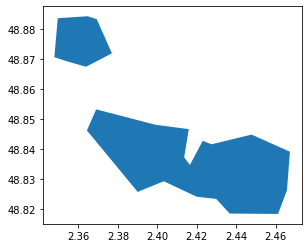

In [115]:
# Inconsistencies in the data
df = data_boundaries_fra[data_boundaries_fra['NAME_3'].str.contains('Paris, 12e')]
df.plot()
df



### Grouping validation

In [138]:
fragmented_cities_lvl4 = get_fragmented_cities_regex(data_boundaries_fra, level=4)
fragmented_cities_lvl3 = get_fragmented_cities_regex(data_boundaries_fra, level=3)

n_frag_cities_lvl4 = sum(len(i[1])-1 for i in fragmented_cities_lvl4)
n_frag_cities_lvl3 = sum(len(i[1])-1 for i in fragmented_cities_lvl3)

assert n_frag_cities_lvl4 == len(data_boundaries_fra) - len(update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl4, level=4))
assert n_frag_cities_lvl3 == len(data_boundaries_fra.dissolve('NAME_3')) - len(update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl3, level=3))


2022-03-01 20:20:03,282 | WARNING : Level 4+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.
2022-03-01 20:20:06,008 | WARNING : Level 3+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.


3728


2022-03-01 20:06:33,802 | WARNING : Level 3+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.


3728


2022-03-01 20:06:34,675 | WARNING : Level 4+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.


<AxesSubplot:>

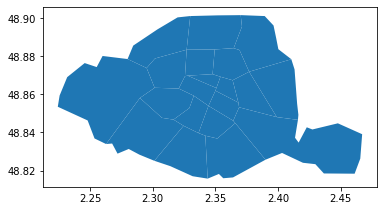

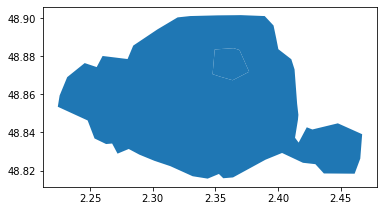

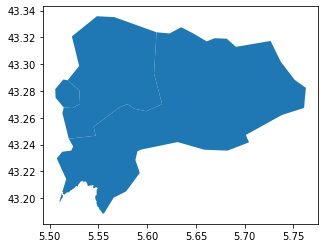

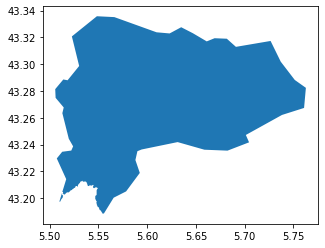

In [119]:
print(len(data_boundaries_fra))
print(len(data_boundaries_fra.dissolve(['NAME_3', 'NAME_4'])))

# GADM level 3
fragmented_cities_lvl3 = get_fragmented_cities_regex(data_boundaries_fra, level=3)

data_boundaries_paris = data_boundaries_fra[data_boundaries_fra['NAME_3'].str.contains('Paris')]
data_boundaries_paris.plot()

data_boundaries_paris_new = update_gadm_boundaries(data_boundaries_paris, fragmented_cities_lvl3, level=3)
data_boundaries_paris_new.plot()

# GADM level 4
fragmented_cities_lvl4 = get_fragmented_cities_regex(data_boundaries_fra, level=4)

data_boundaries_aubagne = data_boundaries_fra[data_boundaries_fra['NAME_4'].str.contains('Aubagne')]
data_boundaries_aubagne.plot()

data_boundaries_aubagne_new = update_gadm_boundaries(data_boundaries_aubagne, fragmented_cities_lvl4, level=4)
data_boundaries_aubagne_new.plot()




## Experiments

In [65]:
df = data_boundaries[data_boundaries['NAME_4'] == 'Thuir']
df.groupby(['NAME_1', 'NAME_2', 'NAME_3'])['NAME_4'].apply(list).values
# data_boundaries[data_boundaries['NAME_4'].str.contains('Fürth')]


array([list(['Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir'])],
      dtype=object)

In [237]:
df = data_boundaries[data_boundaries['NAME_0'] == 'France']

get_fragmented_cities_regex(df, level=3)

[['Thionville-Est', 'Thionville-Ouest'],
 ['Paris, 11e arrondissement',
  'Paris, 12e arrondissement',
  'Paris, 13e arrondissement',
  'Paris, 14e arrondissement',
  'Paris, 15e arrondissement',
  'Paris, 16e arrondissement',
  'Paris, 17e arrondissement',
  'Paris, 18e arrondissement',
  'Paris, 19e arrondissement',
  'Paris, 1er arrondissement',
  'Paris, 20e arrondissement',
  'Paris, 2e arrondissement',
  'Paris, 3e arrondissement',
  'Paris, 4e arrondissement',
  'Paris, 5e arrondissement',
  'Paris, 6e arrondissement',
  'Paris, 7e arrondissement',
  'Paris, 8e arrondissement',
  'Paris, 9e arrondissement']]

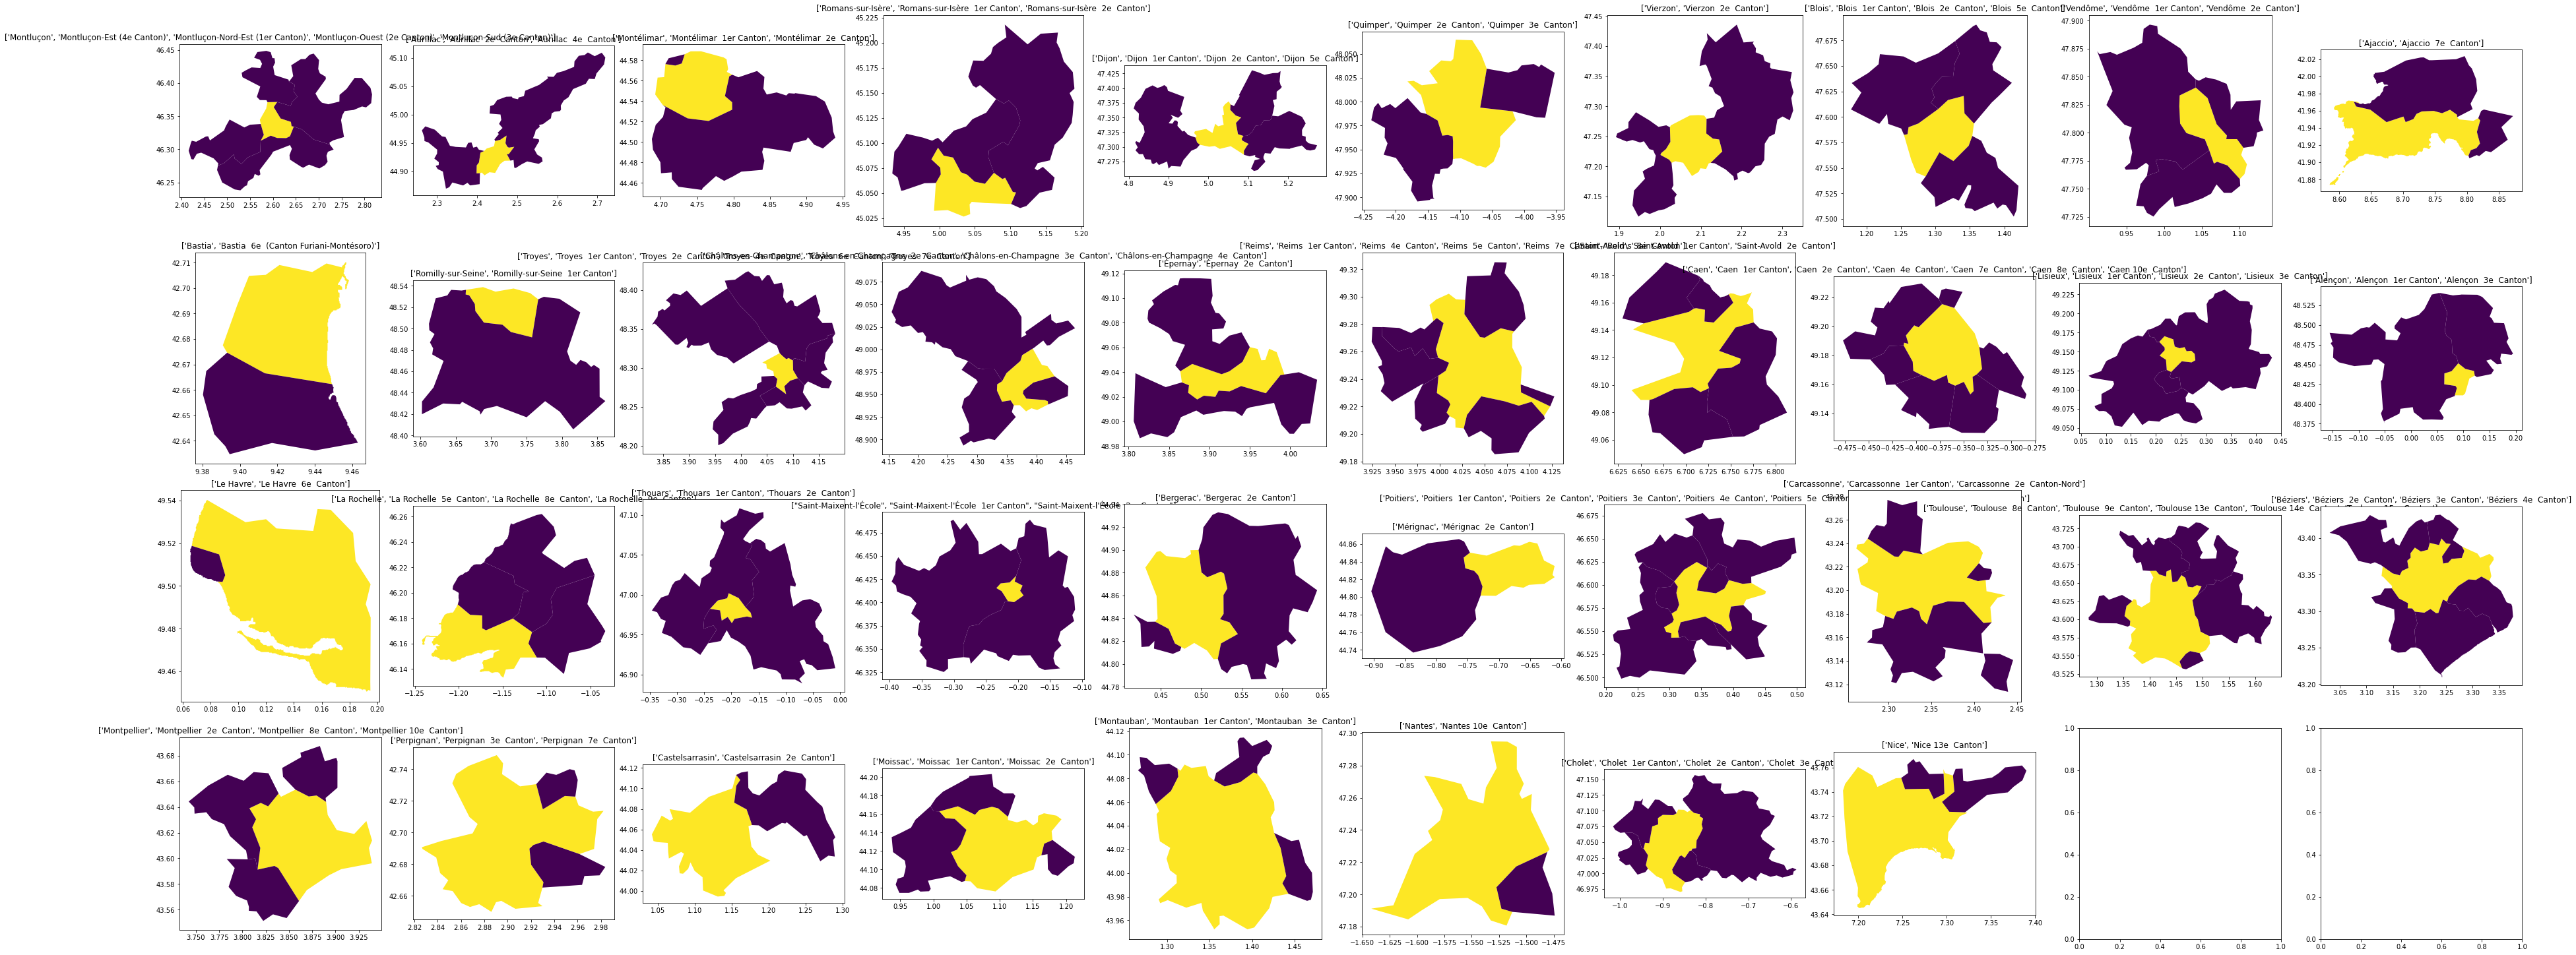

In [27]:
frag_cities_fr = get_fragmented_cities_regex(data_boundaries_fra, level=4)
canton_frag_cities_fr = [frags for frags in frag_cities_fr if any('Canton' in frag for frag in frags)]

df = data_boundaries_fra.copy()
df['not_canton'] = ~df['NAME_4'].str.contains('Canton')

fragmented_cities = [['Toulouse',
    'Toulouse  8e  Canton',
    'Toulouse  9e  Canton',
    'Toulouse 13e  Canton',
    'Toulouse 14e  Canton',
    'Toulouse 15e  Canton'],
    ['Béziers',
    'Béziers  2e  Canton',
    'Béziers  3e  Canton',
    'Béziers  4e  Canton']]

visual_validation(canton_frag_cities_fr, df, level=4, column_color_coding='not_canton')


<AxesSubplot:>

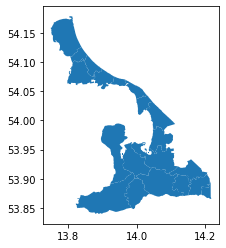

In [75]:
data_boundaries[data_boundaries['NAME_3'].isin(['Usedom-Nord', 'Usedom-Süd'])].plot()


<AxesSubplot:>

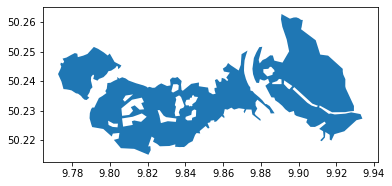

In [76]:
data_boundaries[data_boundaries['NAME_3'].isin(['Geiersnest-Ost', 'Geiersnest-West'])].plot()


<AxesSubplot:>

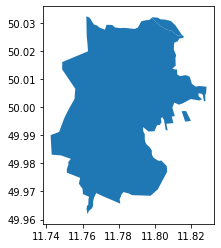

In [79]:
data_boundaries[data_boundaries['NAME_3'].isin(['Warmensteinacher Forst-Nord', 'Warmensteinach'])].plot()


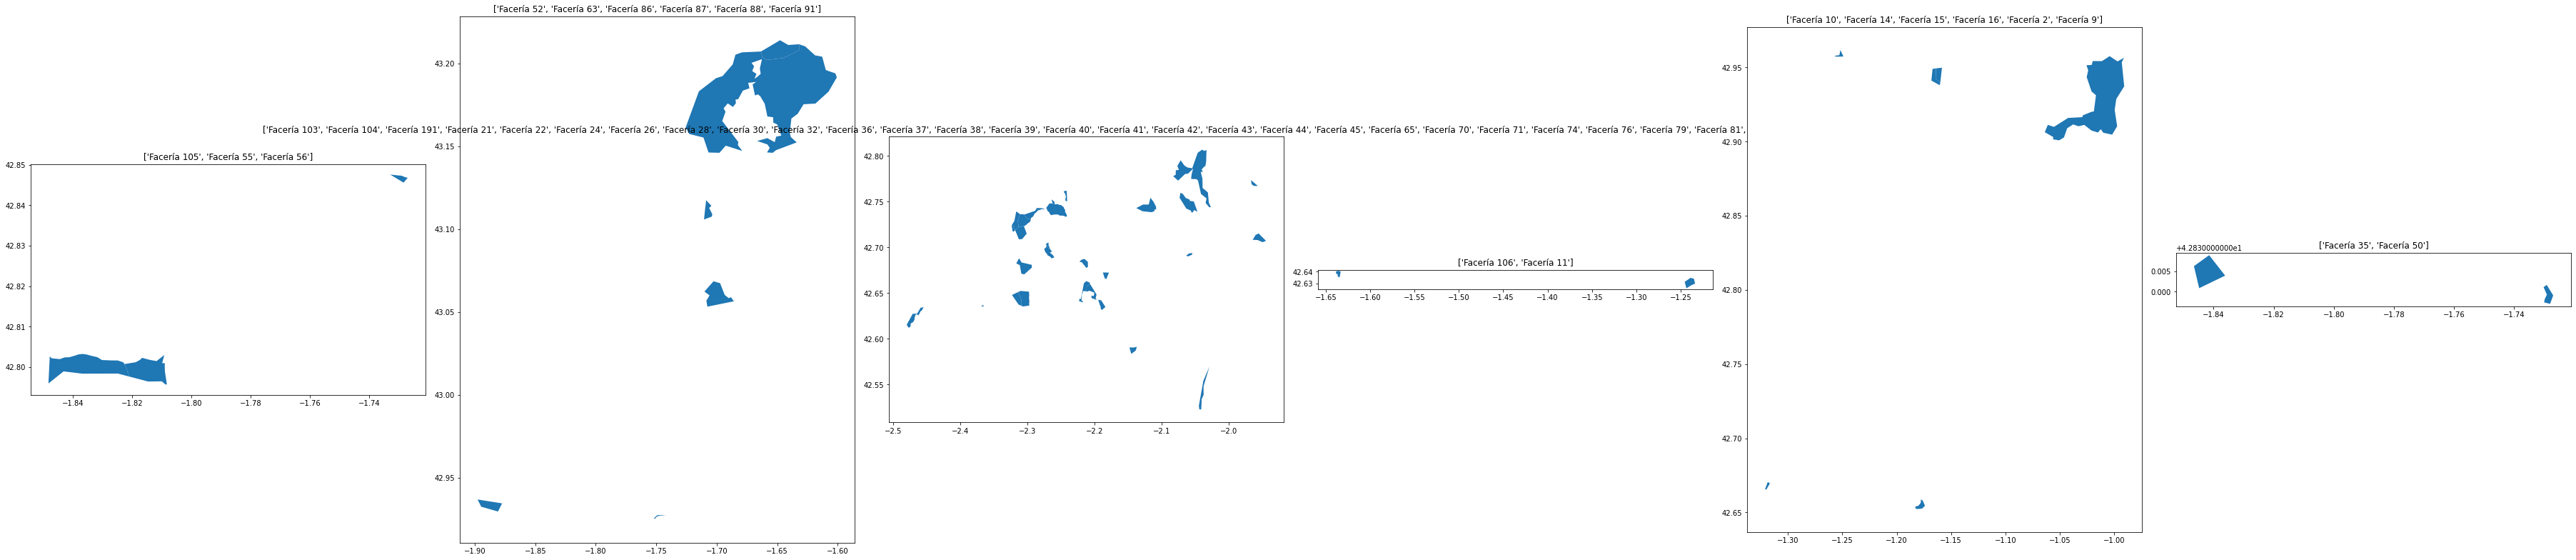

In [197]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain') & (data_boundaries['NAME_4'].str.contains('Facería'))]
frag_cities = get_fragmented_cities_clustering(df, level=4)[:11]
visual_validation(frag_cities, df, level=4)




#### Analysis Facería XX regions in Spain

<AxesSubplot:>

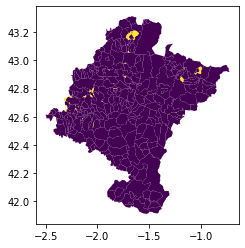

In [151]:
# %matplotlib qt
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain')].copy()
df['Facería_region'] = df['NAME_4'].str.contains('Facería')
df[df['NAME_2'] == 'Navarra'].plot(column='Facería_region')
# --> not a fragmented city / region!

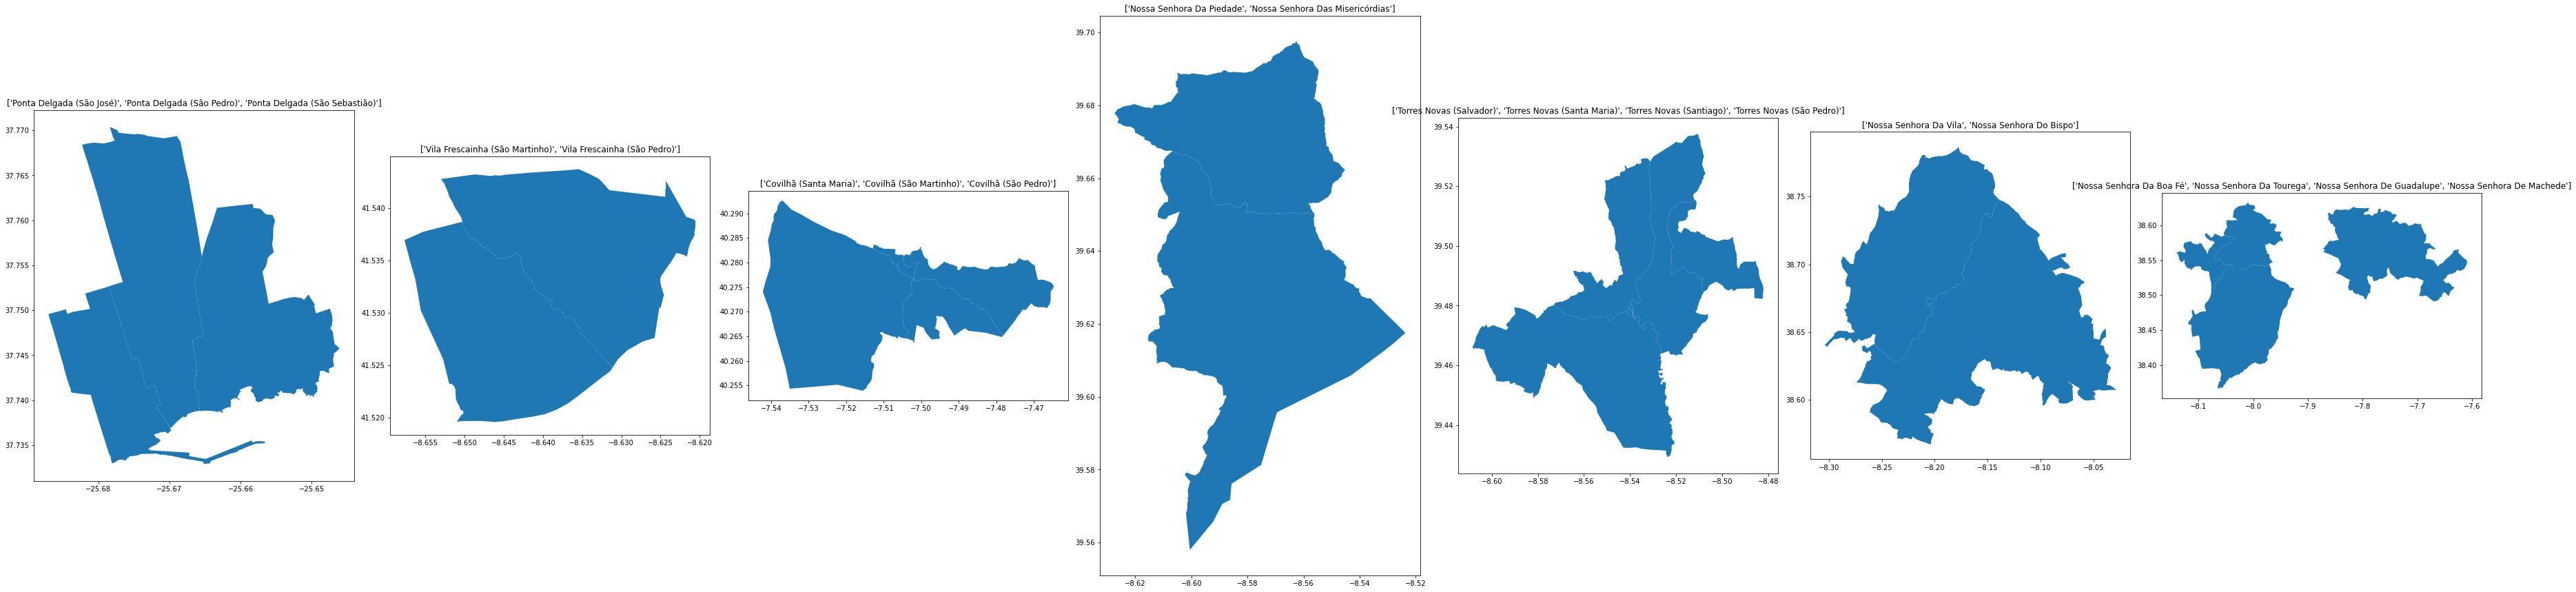

In [190]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'Portugal') & (data_boundaries['NAME_3'].str.contains('Ponta Delgada|Vila Frescainha|Covilhã|Torres Novas|Nossa Senhora'))]
frag_cities = get_fragmented_cities_clustering(df, level=3)
visual_validation(frag_cities, df, level=3)

NAME_2                 NAME_3                 NAME_4 NAME_5
94098              Berlin                 Berlin                 Berlin       
94100              Barnim      Bernau bei Berlin      Bernau bei Berlin       
94254   Märkisch-Oderland  Neuenhagen bei Berlin  Neuenhagen bei Berlin       
94259   Märkisch-Oderland  Rüdersdorf bei Berlin  Rüdersdorf bei Berlin       
94341          Oder-Spree  Schöneiche bei Berlin  Schöneiche bei Berlin       
99138         Vulkaneifel             Gerolstein              Berlingen       
101299          Eichsfeld   Lindenberg/Eichsfeld           Berlingerode

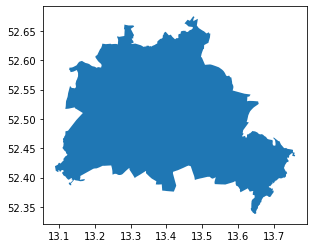

In [212]:
# frag_cities_es = get_fragmented_cities_clustering(df_ger, level=3)
# mlk_frag_cities_es = [frags for frags in frag_cities_es if any(s in frag for frag in frags for s in potential_substrings)]
# visual_validation(mlk_frag_cities_es, df_ger, level=3)
data_boundaries[data_boundaries['NAME_4'] == 'Berlin'].plot()
data_boundaries[(data_boundaries['NAME_0'] == 'Germany') & (data_boundaries['NAME_4'].str.contains('Berlin'))][['NAME_2', 'NAME_3', 'NAME_4', 'NAME_5']]

# # --> ?

#### Visualizing 'accepted errors' in France

57947    Aix-les-Bains-Nord-Grésy
57948    Aix-les-Bains-Nord-Grésy
57949    Aix-les-Bains-Nord-Grésy
57950    Aix-les-Bains-Nord-Grésy
57951    Aix-les-Bains-Nord-Grésy
57952    Aix-les-Bains-Nord-Grésy
57953    Aix-les-Bains-Nord-Grésy
57954           Aix-les-Bains-Sud
57955           Aix-les-Bains-Sud
57956           Aix-les-Bains-Sud
57957           Aix-les-Bains-Sud
57958           Aix-les-Bains-Sud
57959           Aix-les-Bains-Sud
57960               Aix-les-Bains
Name: NAME_4, dtype: object

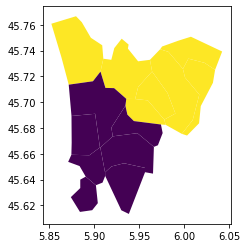

In [167]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'France')].copy()
# df = data_boundaries_fra.copy()

df = df[df['NAME_4'].str.contains('Aix-les-Bains')]
df['Aix-les-Bains-Nord-Grésy'] = df['NAME_4'].isin(['Aix-les-Bains-Nord-Grésy', 'Aix-les-Bains-Grésy'])
df.plot(column='Aix-les-Bains-Nord-Grésy')
df['NAME_4']

54407       Domérat-Montluçon-Nord-Ouest
54466          Montluçon-Est (4e Canton)
54467          Montluçon-Est (4e Canton)
54468          Montluçon-Est (4e Canton)
54469          Montluçon-Est (4e Canton)
54470          Montluçon-Est (4e Canton)
54471    Montluçon-Nord-Est (1er Canton)
54472    Montluçon-Nord-Est (1er Canton)
54473        Montluçon-Ouest (2e Canton)
54474        Montluçon-Ouest (2e Canton)
54475        Montluçon-Ouest (2e Canton)
54476          Montluçon-Sud (3e Canton)
54477          Montluçon-Sud (3e Canton)
54478          Montluçon-Sud (3e Canton)
54479          Montluçon-Sud (3e Canton)
54480                          Montluçon
Name: NAME_4, dtype: object

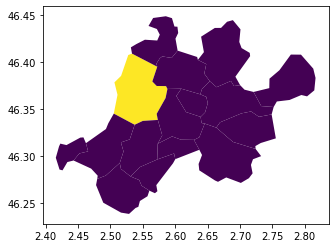

In [171]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'France')].copy()

df = df[df['NAME_4'].str.contains('Montluçon')]
df['Domérat'] = df['NAME_4'].isin(['Domérat-Montluçon-Nord-Ouest'])
df.plot(column='Domérat')
df['NAME_4']

2022-03-02 10:49:48,157 | WARNING : Level 4+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.
2022-03-02 10:49:49,508 | WARNING : Level 4+ attributes of first fragment will be used when aggregating fragments, rendering attributes like GID_4 misleading.


<AxesSubplot:>

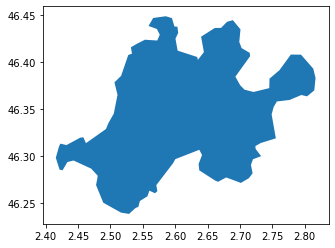

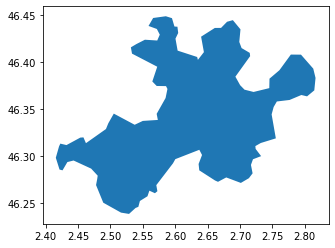

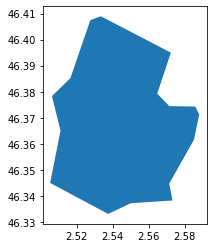

In [234]:
fragmented_cities_lvl4 = get_fragmented_cities_regex(data_boundaries_fra, level=4)

fragmented_cities_lvl4_old = fragmented_cities_lvl4.copy()
fragmented_cities_lvl4.extend(special_cases_lvl4)

df1 = update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl4_old, level=4)
df2 = update_gadm_boundaries(data_boundaries_fra, fragmented_cities_lvl4, level=4)

dup = pd.concat([df1, df2]).drop_duplicates(keep=False)

dup[dup.index == 45].plot()
dup[dup.index == 46].plot()
dup[dup.index == 42].plot()


### GADM version 3.6

In [213]:
data_boundaries_36 = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm36.gpkg'))

In [226]:
set(data_boundaries_36[data_boundaries_36['NAME_0'].isin(european_countries)]['NAME_3'].unique()).symmetric_difference(data_boundaries[data_boundaries['NAME_0'].isin(european_countries)]['NAME_3'].unique())

{' ',
 ' Võrtsjärve',
 'Amari',
 'Amari ',
 'Aristotelis',
 'Aristotelis ',
 'Bascharage',
 'Boevange-sur-Attert',
 'Burmerange',
 'City of London',
 'City of Westminster',
 'Clemency',
 'Consthum',
 'Corinth',
 'Corinth ',
 'Cythera',
 'Cythera ',
 'Ermsdorf',
 'Erymanthos',
 'Erymanthos ',
 'Essex',
 'Evrotas',
 'Evrotas ',
 'Habscht',
 'Heiderscheid',
 'Helperknapp',
 'Hobscheid',
 'Hoscheid',
 'Hosingen',
 'Hydra',
 'Hydra ',
 'Käerjeng',
 'Lokroi',
 'Lokroi ',
 'London',
 'Medernach',
 'Mompach',
 'Munshausen',
 'Neunhausen',
 'Nikolaos Skoufas',
 'Nikolaos Skoufas ',
 None,
 'Nüziders',
 'N�ziders',
 'Orchomenus',
 'Orchomenus ',
 'Paionia',
 'Paionia ',
 'Parc Hosingen',
 'Pineios',
 'Pineios ',
 'Rosport',
 'Rosport-Mompach',
 'Septfontaines',
 'Sparti',
 'Sparti ',
 'Tempi',
 'Tempi ',
 'Tuntange',
 "Vallée de l'Ernz",
 'Voio',
 'Voio ',
 'Võrtsjärve',
 'Wellenstein',
 'Westminster'}

#### Differences in clustering between GADM 3.6 and 4.0 -> (pretty much) None

In [228]:
df = data_boundaries_36.copy()
df['NAME_3'] = df['NAME_3'].astype(str)
df['NAME_4'] = df['NAME_4'].astype(str)
df = df.drop_duplicates(subset=['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'NAME_4'])

for level in [3, 4]:

    candidates = {}
    for country in european_countries:
        data_boundaries_country = df[df['NAME_0'] == country]
        candidates[country] = get_fragmented_cities_clustering(data_boundaries_country, level=level)

    with open(os.path.join('..', 'data', f'fragmented-cities-candidates-clustering-level-{level}-36.json'), 'w', encoding='utf8') as f:
        json.dump(candidates, f, sort_keys=True, indent=4, ensure_ascii=False)
